In [1]:
import tensorflow as tf 
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist, mnist
import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
import matplotlib.pyplot as plt
!rm -rf logs/fit

# Create networks with different shapes

Create a model with:
- one input layer for datashapes (batch x 10), so 10 features per observation
- one deep layer of 30 units
- one outputlayer, with an output of (batch x 1), so 1 number.

In [2]:
input = Input(shape=10)
x = Dense(30)(input)
output = Dense(1)(x)

model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 30)                330       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [3]:
assert (model._input_layers[0].input_shape[0][1] == 10) 
assert (len(model._input_layers) == 1) 
assert (len(model.layers) == 3) 
assert (model.layers[1].output_shape[1] == 30) 
assert (len(model._output_layers) == 1)
assert (model._output_layers[0].output_shape[1] == 1)

Create a model that has:
- two input layers (`a` and `b`), both for data with shape (batch x 10)
- input `a` feeds into a Dense layer with 50 units
- the output of that Dense layer is concatenated with input `b`, and outputs a layer of shape (batch x 60)
- the concatenated layers are fed into a Dense layer with a single unit, which is the output of the model.

In [4]:
inputa = Input(shape=10)
inputb = Input(shape=10)

x1 = Dense(50)(inputa)
x2 = tf.concat([x1, inputb], 1)

output = Dense(1)(x2)

model = Model(inputs=[inputa, inputb], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           550         input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
tf.concat (TFOpLambda)          (None, 60)           0           dense_2[0][0]                    
                                                                 input_3[0][0]              

In [13]:
assert len(model._input_layers) == 2 
assert (model._input_layers[0].input_shape[0][1] == 10 & model._input_layers[1].input_shape[0][1] == 10) 
assert model.layers[1].output_shape[1] == 50
assert model.layers[3].output_shape[1] == 60
assert model.layers[4].output_shape[1] == 1

In [14]:
inputa = Input(shape=10)
inputb = Input(shape=10)

x1 = Dense(50)(inputa)
x2 = tf.concat([x1, inputb], 1)

output = Dense(1)(x2)

model = Model(inputs=[inputa, inputb], outputs=[output, x1])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 50)           550         input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
tf.concat_2 (TFOpLambda)        (None, 60)           0           dense_6[0][0]                    
                                                                 input_7[0][0]              

In [16]:
assert len(model._input_layers) == 2 
assert (model._input_layers[0].input_shape[0][1] == 10 & model._input_layers[1].input_shape[0][1] == 10) 
assert model.layers[1].output_shape[1] == 50
assert model.layers[3].output_shape[1] == 60
assert model.layers[4].output_shape[1] == 1
assert len(model._output_layers) == 2

# Create a model for MNIST
## prepare data

We load the mnist dataset and make a train-test split. Make sure the random_state and size does not change, because that will influence the `assert` tests later on.

Note that in a real life setting you should ONLY use `random_state` if you want to guarantee that the split comes out exactly the same every time you make it.

In [17]:
#(X_train, y_train), (X_valid, y_valid) = fashion_mnist.load_data()
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()
from sklearn.model_selection import train_test_split
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.4, random_state=42)

In [18]:
X_train.shape, X_valid.shape, X_test.shape

((60000, 28, 28), (6000, 28, 28), (4000, 28, 28))

4

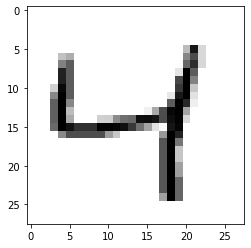

In [19]:
idx = 2 #let's have a look at case 25. You can change this to have a look at others
digit = X_train[idx]
plt.imshow(digit, cmap='binary')
y_train[idx]

In [20]:
# the y are categories, ranging from 0 to 9.
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [21]:
# we scale the data, simply between [0,1]
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

## Create baseline model

In [22]:
# first, we reshape
X_trainr = X_train.reshape(X_train.shape[0], -1)
X_testr = X_test.reshape(X_test.shape[0], -1)
X_trainr.shape

(60000, 784)

After reshaping, we have size (batch x features)

In [23]:
# usefull for plotting heatmaps of a confusion matrix
import seaborn as sns
def cfm_heatmap(cfm, figsize = (8,8), scale = None, vmin=None, vmax=None):
    """
    figsize: tuple, default (8,8)
    scale: string. The direction over which the numbers are scaled. Either None, 'total', 'rowwise' or 'colwise'
    """
    if (scale == 'total'):
        cfm_norm = cfm / np.sum(cfm)
    elif (scale == 'rowwise'):
        cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
    elif (scale == 'colwise'):
        cfm_norm = cfm / np.sum(cfm, axis=0, keepdims=True)
    else:
        cfm_norm = cfm
    plt.figure(figsize=figsize)
    plot = sns.heatmap(cfm_norm, annot = cfm_norm, vmin=vmin, vmax=vmax)
    plot.set(xlabel = 'Predicted', ylabel = 'Target')


Create a basic classifier. The simplest is a `SGDClassifier`. Make one, fit, predict and make a confusion matrix. Tip: speed it up with `n_jobs`.

In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

sgd = SGDClassifier(random_state=42, n_jobs=4)
sgd.fit(X_trainr, y_train)
yhat = sgd.predict(X_testr)

cfm = confusion_matrix(y_test, yhat)

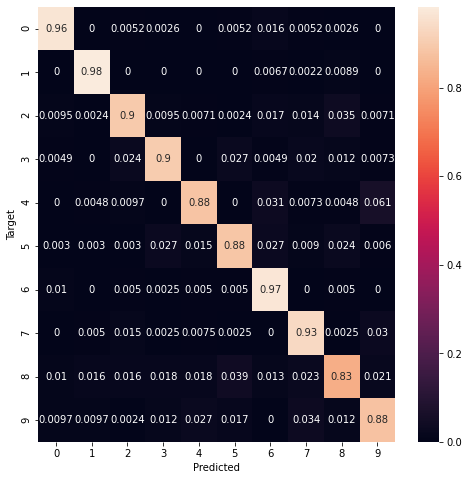

In [25]:
cfm_heatmap(cfm, scale = 'rowwise')

And test the accuracy. This is the baseline you want to improve on.

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, yhat)

0.912

In [27]:
assert accuracy_score(y_test, yhat) > 0.9

# Create Deep Neural Network

Now create a Sequential model. Try some variations with amounts of layers and units. 
Experiment with the following things:

- different amounts of layers
- different amounts of units in every layer
- pick a `sparse_categorical_crossentropy` for training, add as metric `accuracay`

In [28]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model = Sequential([
    Flatten(),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 1ms/step - loss: 0.1227 - accuracy: 0.9622


[0.12268485873937607, 0.9622499942779541]

In [29]:
log_dir = "logs/fit/" + "neuron_100"

model = Sequential([
    Flatten(),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9753


[0.09034495800733566, 0.9752500057220459]

In [30]:
assert model.evaluate(X_test, y_test)[1] > 0.96

125/125 [==============================] - 0s 1ms/step - loss: 0.0903 - accuracy: 0.9753


Build a hypermodel.

define ranges for
- amounts of units (at least between 128 and 320)
- amounts of layser (range at least between 1 and 6)

In [31]:
def build_model(hp):
    input = Input(shape = [28,28])
    flat = Flatten()(input)

    units = hp.Int('units', 128, 320, 64)
    act = hp.Choice('act', ['relu', 'elu', 'selu'])
    x = Dense(units, activation=act)(flat)

    for i in range(hp.Int('dense_layers', 1, 5)):
        name = 'layer_{0}'.format(i)
        x = Dense(units=units, activation=act, name=name)(x)
    
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs = [input], outputs = [output])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model

In [32]:
import kerastuner as kt
# cleaning up folders from old runs
!rm -rf ktuner/

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=3,
    directory='ktuner',
    project_name='mnist'
)
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid), verbose=1)

Trial 6 Complete [00h 00m 15s]
val_loss: 0.18900403380393982

Best val_loss So Far: 0.09227125346660614
Total elapsed time: 00h 00m 47s
INFO:tensorflow:Oracle triggered exit


In [33]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
model = tuner.get_best_models()[0]
model.summary()

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)

{'units': 256, 'act': 'relu', 'dense_layers': 2, 'tuner/epochs': 3, 'tuner/initial_epoch': 1, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '9e0bde99e9ce77440aa7725c391a7ad9'}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
layer_0 (Dense)              (None, 256)               65792     
_________________________________________________________________
layer_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_1

In [35]:
assert model.evaluate(X_test, y_test)[1] > 0.975

125/125 [==============================] - 0s 1ms/step - loss: 0.0826 - accuracy: 0.9760


In [61]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization

def build_model(hp):
    input = Input(shape = [28,28, 1])
    
    filters = hp.Int('filters', 16, 32, 4)
    x = Conv2D(filters, 3, activation='relu')(input)
    x = MaxPool2D((2,2))(x)
    
    for i in range(hp.Int('conv_layers', 0, 3)):
        x = Conv2D(filters, 3, activation='relu')(x)
        x = MaxPool2D((2,2))(x)
        name = 'convlayer_{0}'.format(i)
        
    flat = Flatten()(x)

    units = hp.Int('units', 128, 320, 64)
    #act = hp.Choice('act', ['relu', 'elu', 'selu'])
    act = 'relu'

    x = Dense(units, activation=act)(flat)
    x = BatchNormalization()(x)


    for i in range(hp.Int('dense_layers', 1, 5)):
        name = 'layer_{0}'.format(i)
        x = Dense(units=units, activation=act)(x)
        x = BatchNormalization()(x)
    
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs = [input], outputs = [output])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model

In [62]:
import kerastuner as kt
# cleaning up folders from old runs
!rm -rf ktuner/

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=5,
    directory='ktuner',
    project_name='mnist'
)
tuner.search(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid), verbose=1)

Trial 10 Complete [00h 01m 11s]
val_loss: 0.032910726964473724

Best val_loss So Far: 0.029305661097168922
Total elapsed time: 00h 09m 17s
INFO:tensorflow:Oracle triggered exit


In [63]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
cnn_model = tuner.get_best_models()[0]
cnn_model.summary()

history = cnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 1)
cnn_model.evaluate(X_test, y_test)

{'filters': 24, 'conv_layers': 1, 'units': 256, 'dense_layers': 1, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': 'f8e546a491f79eba7a4fe9bf89837eae'}
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 24)        240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 24)        5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 24)          0         
________________________________________________

[0.029319841414690018, 0.9909999966621399]

In [ ]:
assert model.evaluate(X_test, y_test)[1] > 0.99